## Neural networks for pucks segmentation

In [1]:
import scipy as sp
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import albumentations
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data as data
from torchvision import utils
import torch.optim as optim
import time
import torchvision.transforms.functional as TF
from scipy.ndimage.interpolation import map_coordinates
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Helper functions

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [30]:
def show_batch(sample_batched, net=None, threshold=0.2):
    sample_batched = iter(sample_batched).next()
    plt.figure(figsize=(15,20))
    # Gridify only two images and masks
    grid_imgs = utils.make_grid(sample_batched[0], padding=2)
    grid_masks = utils.make_grid(sample_batched[1], padding=2)
    grid = torch.cat((grid_imgs, grid_masks), 1)
    # Is network is given then concat also prediction
    if (net is not None):
        with torch.no_grad():
            if (next(net.parameters()).is_cuda == False):
                grid_pred = utils.make_grid((net(sample_batched[0]) > threshold).float(), padding=2)
            else:
                grid_pred = utils.make_grid((net(sample_batched[0].cuda()).cpu() > threshold).float(), padding=2)
        grid = torch.cat((grid, grid_pred ), 1)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    if (net is None):
        plt.title('Batch from dataloader (row 1 - images, row 2 - masks)', size=16)
    else:
        plt.title('Batch from dataloader (row 1 - images, row 2 - masks, row 3 - predicted)', size=16)
    plt.axis('off')
    plt.ioff()
    plt.show()

In [5]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

### Define network

In [6]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=1,
        depth=5,
        wf=4,
        padding=True,
        batch_norm=True,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)
        self.activ = nn.Sigmoid()

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.activ(self.last(x))


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

### Define Early Stopper

In [7]:
from IPython import display

class EarlyStopper():
    def __init__(self, patience=10):
        self.patience = patience
        self.last_score = 0
        self.last_epoch = 0
        self.steps = 0
        self.eps = 1e-3
        self.model_state = None
        self.score_hist = []
        self.epoch_hist = []
        self.train_hist = []
        self.xticks_step = [1, 10, 50]
    def step(self, epoch, model, train_score, score):
        if (self.steps >= self.patience):
            return False
        if (self.eps < (score - self.last_score)):
            self.last_score = score
            self.last_epoch = epoch
            self.model_state = model.state_dict()
            self.steps = 0
        else:
            self.steps = self.steps + 1
        self.plot(epoch, train_score, score)
        return True
    def plot(self, epoch, train_score, score):
        display.clear_output(wait=True)
        self.epoch_hist.append(epoch)
        self.score_hist.append(score)
        self.train_hist.append(train_score)
        if (len(self.epoch_hist) < 3):
            return
        plt.figure(figsize=(15, 7))  
        plt.title("Early stop progress", size=16)
        plt.xlabel("Number of epoch", size=16)
        plt.ylabel("IoU", size=16)
        plt.plot(self.epoch_hist, self.train_hist, c='r', label="Training IoU")
        plt.plot(self.epoch_hist, self.score_hist, c='b', label="Validation IoU")
        plt.axvline(self.last_epoch, ls='dashed', c='b', label='Best val IoU')
        plt.axhline(self.last_score, ls='dashed', c='b')
        plt.xticks(self.epoch_hist[::self.xticks_step[int(np.log10(len(self.epoch_hist)))]])
        plt.legend()
        plt.grid()
        plt.show()

### Define a custom dataloader

In [8]:
def getint(name):
    return int(''.join(c for c in name if c.isdigit()))

class CellLoader(Dataset):
    def __init__(self, image_path, mask_path, val=False):
        # paths to all images and masks
        self.image_arr = sorted(glob.glob(image_path + "/*"),\
                                key=getint)
        if (len(mask_path)):
            self.mask_arr = sorted(glob.glob(mask_path + "/*"),\
                                   key=getint)
        else:
            self.mask_arr = []
        self.data_len = len(self.image_arr)
        
        if (val == False):
            self.transforms = [
                albumentations.Flip(),
                albumentations.Rotate(7),
                albumentations.RandomBrightness(limit=(-0.4, 0.4)),
                albumentations.RandomContrast(limit=(-0.4, 0.4)),
                albumentations.RandomSizedCrop(min_max_height=(500, 1024), width=1024, height=1024),
                albumentations.RandomGamma(),
                albumentations.ChannelShuffle(),
            ]
        else:
            self.transforms = [
            ]

    def __getitem__(self, index):
        single_image = imageio.imread(self.image_arr[index])
        if (len(self.mask_arr) == 0):
            return TF.to_tensor(single_image).float(), self.image_arr[index]
        
        single_mask = (imageio.imread(self.mask_arr[index]) > 0) * 1
        if (len(single_mask.shape) > 2):
            single_mask = single_mask[:,:,0]
        
        if (len(self.transforms)):
            for transform in self.transforms:
                result = transform(image=single_image, mask=single_mask)
                single_image = result['image']
                single_mask = result['mask']

        return TF.to_tensor(single_image).float(),\
               TF.to_tensor(single_mask).float()

    def __len__(self):
        return self.data_len

### Define parameters

In [9]:
EPOCHS = 400
BATCH_SIZE = 2
ds_train = {
    'imgs' : "dataset1024/train/img",
    'mask' : "dataset1024/train/mask"
}
ds_val = {
    'imgs' : "dataset1024/val/img",
    'mask' : "dataset1024/val/mask"
}

### Load datasets

In [10]:
cell_train = CellLoader(image_path=ds_train['imgs'], mask_path=ds_train['mask'])
cell_train_ld = data.DataLoader(cell_train, batch_size=BATCH_SIZE,
                                shuffle=True,  num_workers=1)

cell_val = CellLoader(image_path=ds_val['imgs'], mask_path=ds_val['mask'], val=True)
cell_val_ld = data.DataLoader(cell_val, batch_size=BATCH_SIZE,
                               shuffle=True,  num_workers=1)

### Show some examples

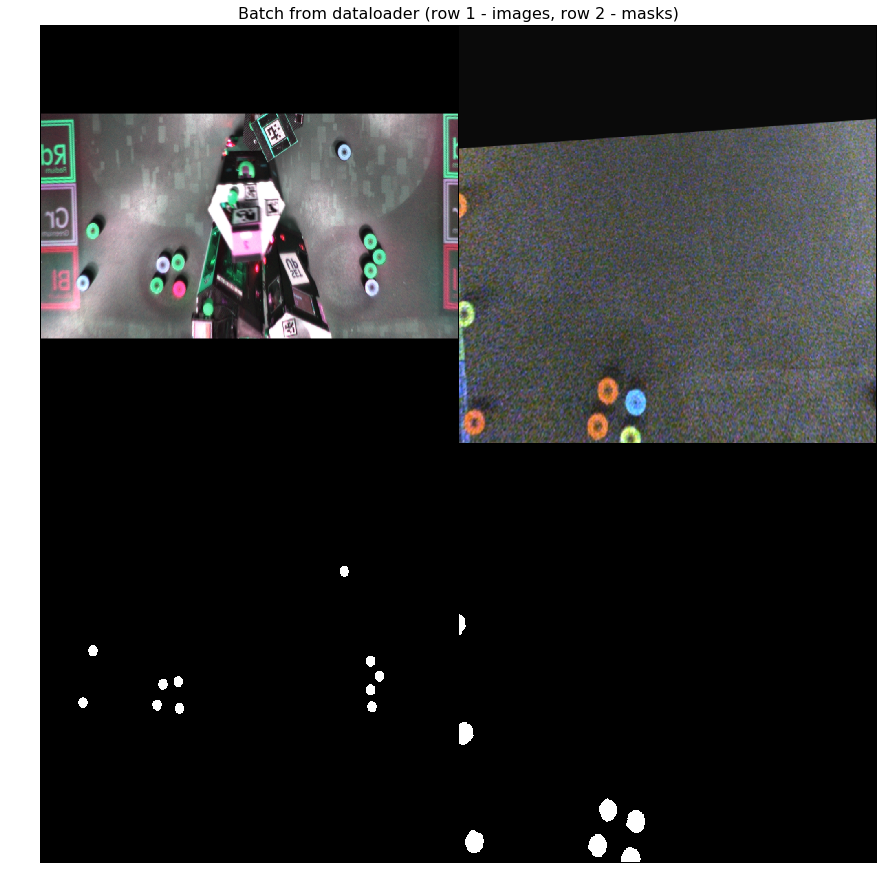

In [11]:
show_batch(cell_train_ld)

### Instantiate the network

In [21]:
net = UNet().to(device)
threshold = 0.4
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
stopper = EarlyStopper(patience=100) 

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=30, verbose=True, min_lr=1e-3)
last_epoch = 0

### Restore the latest checkpoint (if needed)

In [50]:
WEIGHTS_PATH = './weights/fedge_detector_nuc_unet.pth.tar'

if (torch.cuda.is_available()):
    checkpoint = torch.load(f=WEIGHTS_PATH)
else:
    #net = nn.DataParallel(net)
    checkpoint = torch.load(map_location='cpu', f=WEIGHTS_PATH)
    
net.load_state_dict(checkpoint['state_dict'])
#stopper = checkpoint['stopper']
#optimizer.load_state_dict(checkpoint['optimizer'])
#last_epoch = checkpoint['epoch']

### Start training process

In [79]:
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=30, verbose=True, min_lr=1e-4)
threshold = 0.4

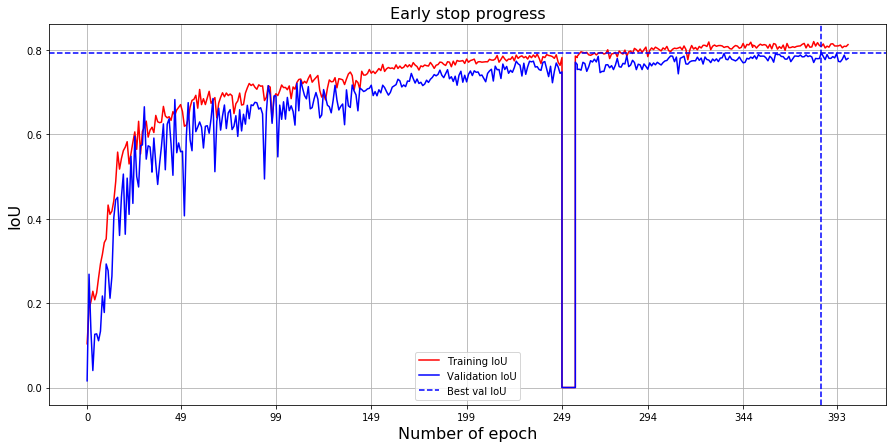

Epoch: 399, Time: 16.62s
Train loss: 0.01
Validation loss: 0.02
Current learning rate:  0.0001


In [80]:
net.zero_grad()
for epoch in range(last_epoch, EPOCHS):
    train_iou = []
    train_loss = []
    net.train() 
    
    start = time.time()
    for steps, (x_batch, y_batch) in enumerate(cell_train_ld):
        optimizer.zero_grad()
        predicted = net(x_batch.to(device))
        bce_loss_val = criterion(predicted, y_batch.to(device).float())
        dice_loss_val = dice_loss(predicted, y_batch.to(device).float())
        loss = bce_loss_val + dice_loss_val
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_iou.append(calc_iou(predicted.detach().cpu().numpy() > threshold,\
                                  y_batch.detach().cpu().numpy()))
    end = time.time()

    val_iou = []
    val_loss = []
    net.eval()
    
    for steps, (x_batch, y_batch) in enumerate(cell_val_ld):
        with torch.no_grad():
            predicted = net(x_batch.to(device))
            bce_loss_val = criterion(predicted, y_batch.to(device).float())
            dice_loss_val = dice_loss(predicted, y_batch.to(device).float())
            loss = bce_loss_val + dice_loss_val
            val_loss.append(loss.item())
            val_iou.append(calc_iou(predicted.detach().cpu().numpy() > threshold,\
                                    y_batch.detach().cpu().numpy()))
    
    scheduler.step(np.mean(val_iou))
    last_epoch = epoch
    if (stopper.step(epoch, net, np.mean(train_iou), np.mean(val_iou))):
        print("Epoch: " + str(epoch) + ", Time: " + str(round(end-start, 2)) + "s")
        print("Train loss: " + str(round(np.mean(train_loss),2)))
        print("Validation loss: " + str(round(np.mean(val_loss),2)))
        for param_group in optimizer.param_groups:
            print("Current learning rate: ", param_group['lr'])
        continue
    else:
        print("Early stop!")
        #net.load_state_dict(stopper.model_state)
        break

### Save checkpoint (be careful)

In [95]:
save_checkpoint({
        #'epoch': epoch,
        'state_dict': net.state_dict(),
        #'stopper' : stopper
        #'optimizer': optimizer.state_dict(),
        #'iou_history' : iou_history,
        #'loss_history' : loss_history,
        #'train_loss_history' : train_loss_history,
        #'train_iou_history' : train_iou_history
    }, './weights/fedge_detector_nuc_unet.pth.tar')

### Demonstrate results (threshold = 0.1)

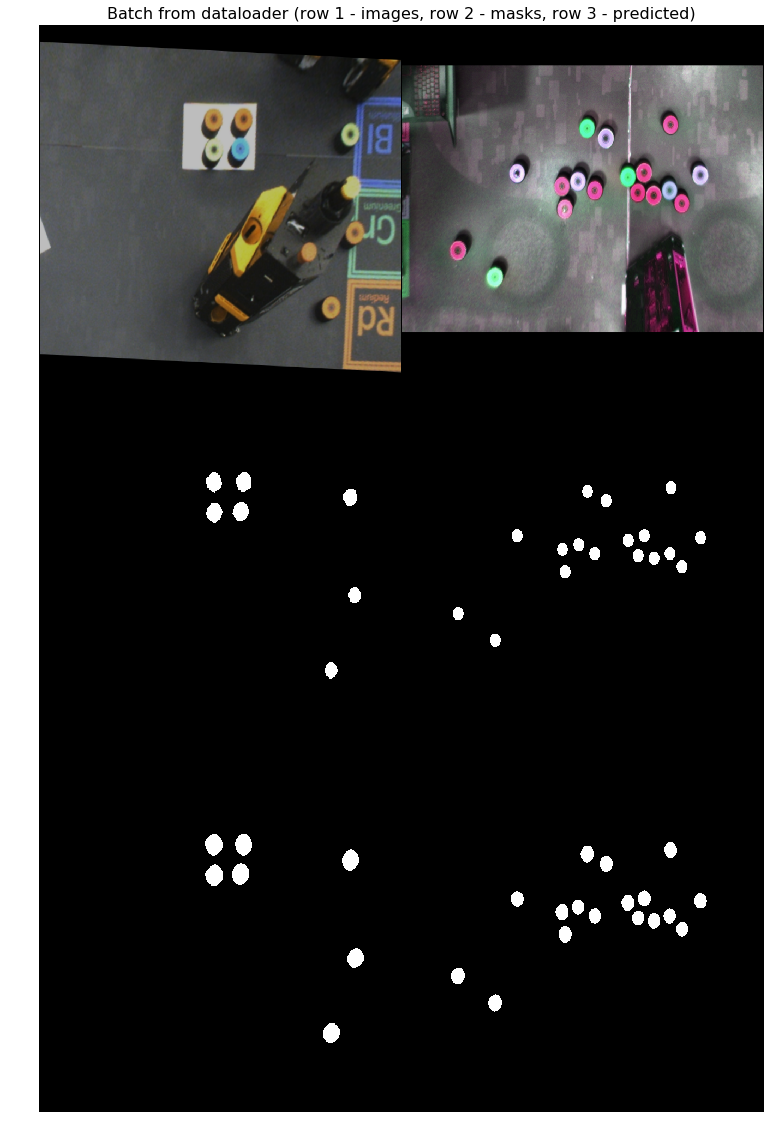

In [24]:
show_batch(cell_train_ld, net, threshold=0.1)

### Demonstrate results (threshold = 0.2)

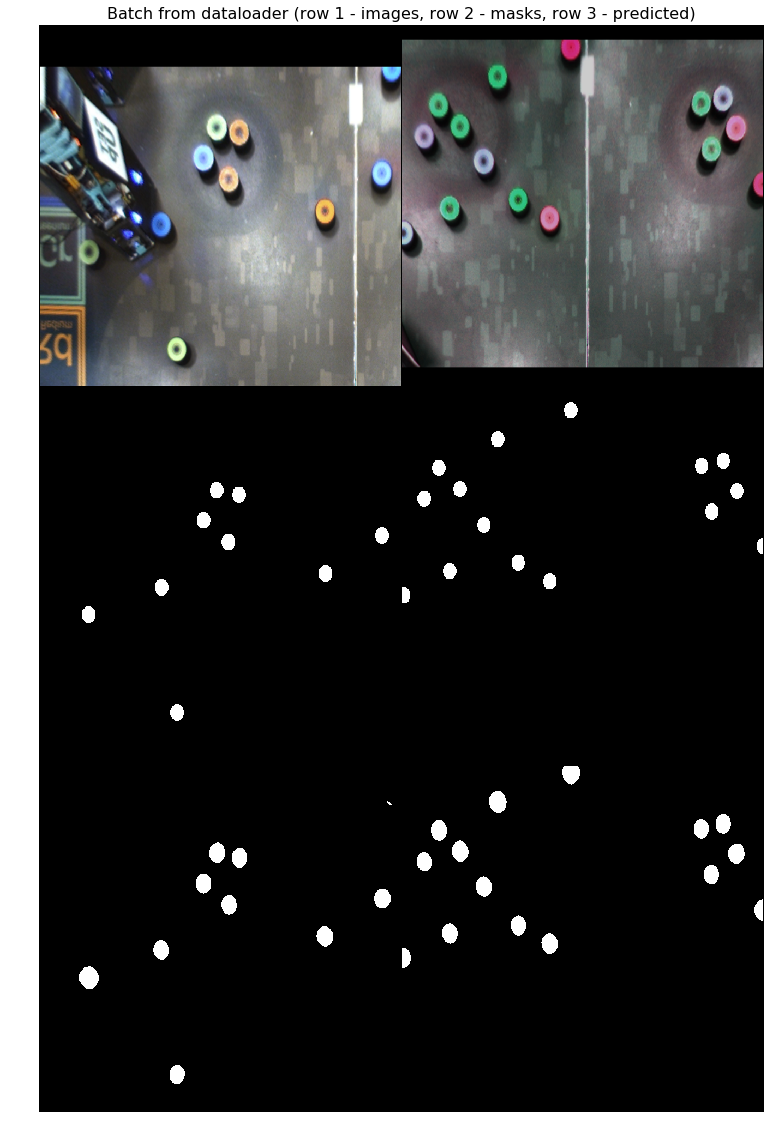

In [40]:
show_batch(cell_train_ld, net, threshold=0.2)

### Demonstrate results (threshold = 0.3)

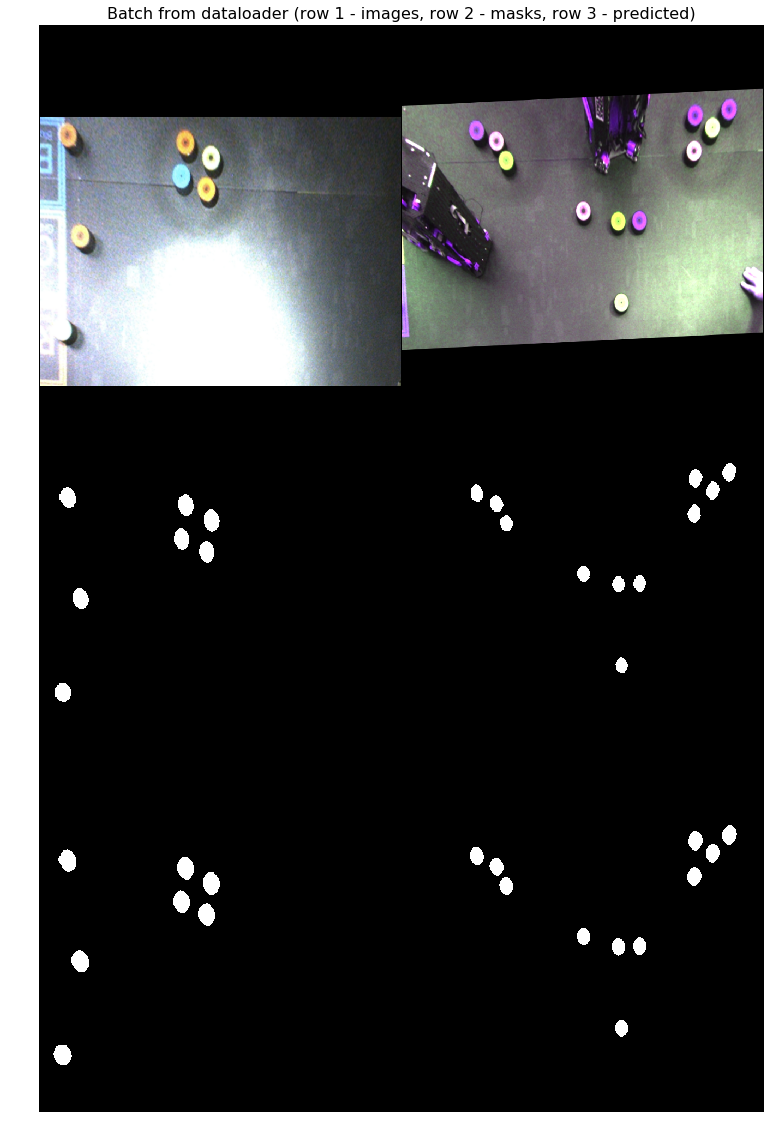

In [41]:
show_batch(cell_train_ld, net, threshold=0.3)

### Demonstrate results (threshold = 0.5)

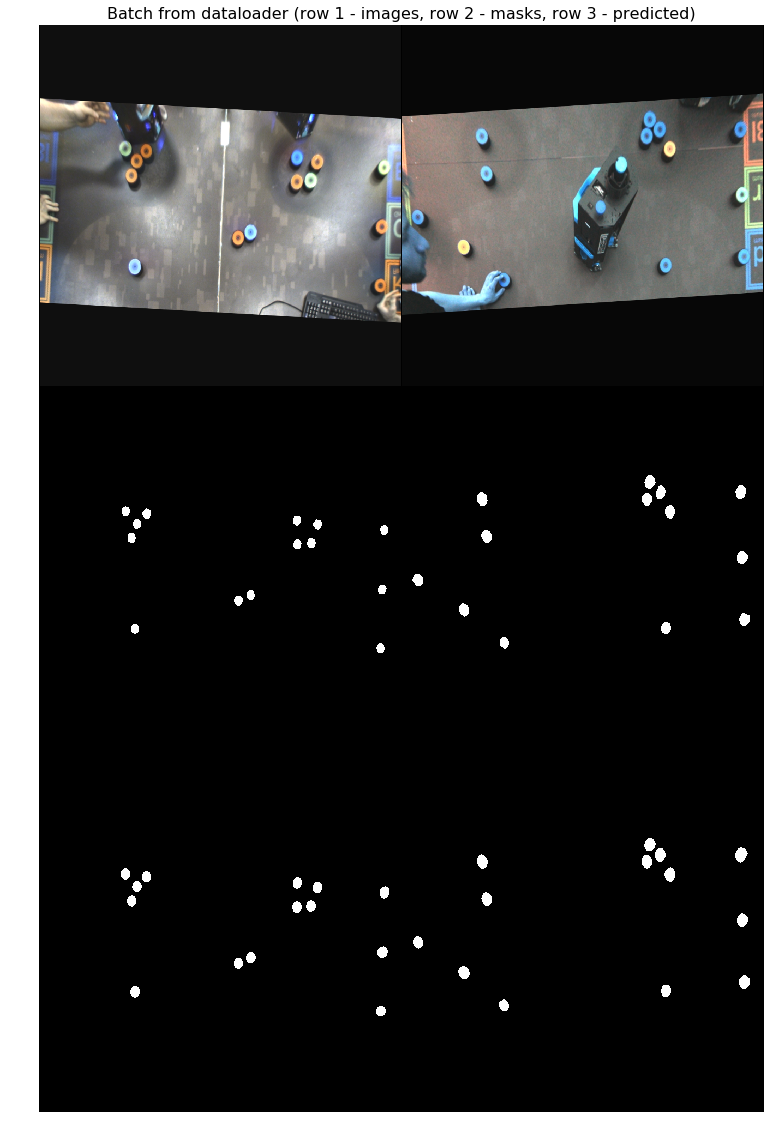

In [42]:
show_batch(cell_train_ld, net, threshold=0.5)

### Save masks for test pictures

In [86]:
ds_test = {
    'imgs' : "dataset1024/test/img",
    'mask' : ""
}

cell_test = CellLoader(image_path=ds_test['imgs'], mask_path=ds_test['mask'], val=True)
cell_test_ld = data.DataLoader(cell_test, batch_size=BATCH_SIZE,
                               shuffle=True, num_workers=1)

In [87]:
TEST_DIR = "./test_mask/"
net.eval()

for x_batch, names in cell_test_ld:
    start = time.time()
    with torch.no_grad():
        masks = (net(x_batch.to(device)) > 0.4)
    end = time.time()
    print(end-start)
    for mask, name in zip(masks, names):
        path, fname = os.path.split(name)
        print(fname, mask.shape)
        imageio.imwrite(TEST_DIR + fname, (mask * 255).squeeze().cpu().numpy().astype(np.uint8))

0.01372671127319336
8.png torch.Size([1, 1024, 1024])
1.png torch.Size([1, 1024, 1024])
0.010656595230102539
4.png torch.Size([1, 1024, 1024])
3.png torch.Size([1, 1024, 1024])
0.010567426681518555
9.png torch.Size([1, 1024, 1024])
2.png torch.Size([1, 1024, 1024])
0.010208606719970703
10.png torch.Size([1, 1024, 1024])
5.png torch.Size([1, 1024, 1024])
0.010751962661743164
7.png torch.Size([1, 1024, 1024])
6.png torch.Size([1, 1024, 1024])
0.007955312728881836
0.png torch.Size([1, 1024, 1024])


### Check test masks

In [88]:
ds_test = {
    'imgs' : "dataset1024/test/img",
    'mask' : "test_mask"
}
cell_test = CellLoader(image_path=ds_test['imgs'], mask_path=ds_test['mask'], val=True)
cell_test_ld = data.DataLoader(cell_test, batch_size=BATCH_SIZE,
                               shuffle=True,  num_workers=1)

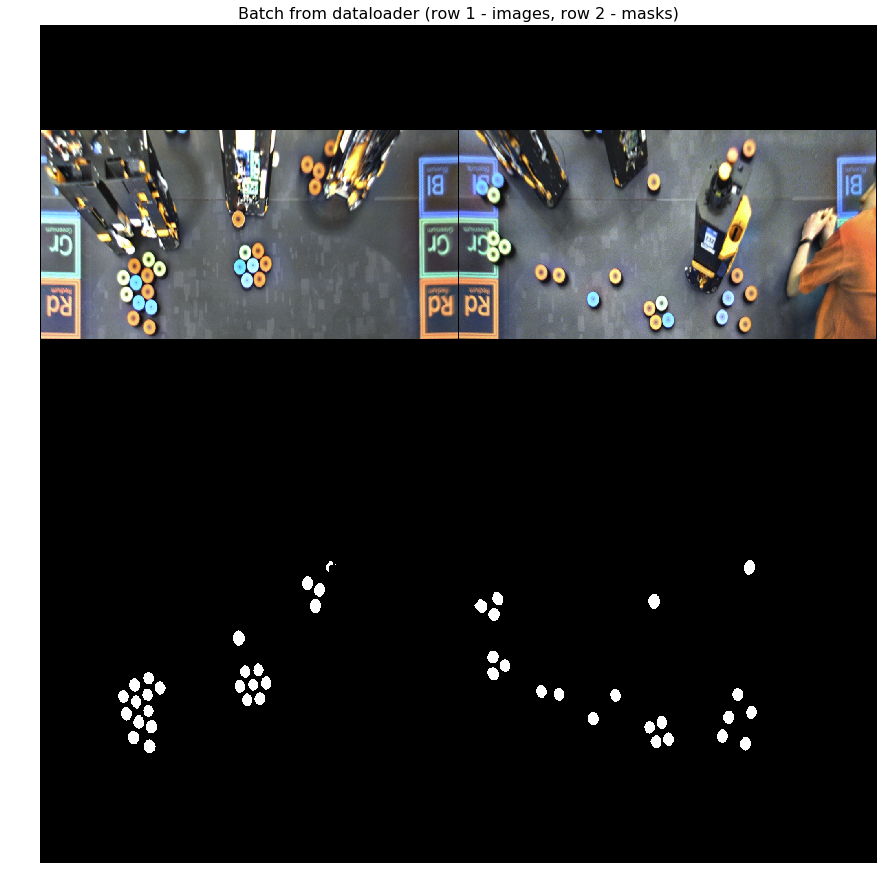

In [94]:
show_batch(cell_test_ld)

### Choose the best threshold

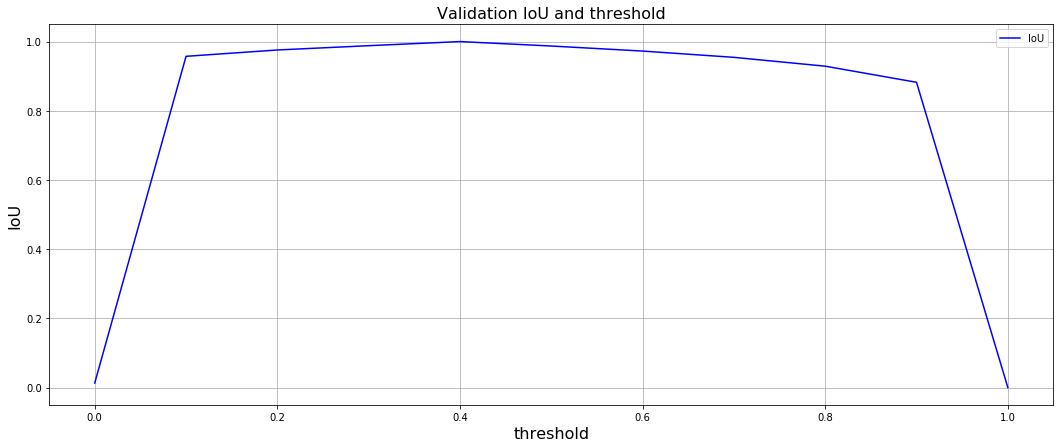

In [37]:
iou = np.empty(0)

for threshold in np.linspace(0,1,11):
    iou_new = np.empty(0)
    for x_batch, target_masks in cell_test_ld:
        with torch.no_grad():
            masks = (net(x_batch.cuda()) > threshold)
        iou_new = np.append(iou_new, calc_iou(masks.cpu().numpy(), target_masks.numpy()))
    iou = np.append(iou, iou_new.mean())
    
plt.figure(figsize=(18, 7))
plt.title("Validation IoU and threshold", size=16)
plt.xlabel("threshold", size=16)
plt.ylabel("IoU", size=16)
plt.plot(np.linspace(0,1,11), iou, 'b', label="IoU")
plt.legend()
plt.grid()
plt.show()